In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

2025-07-14 14:09:47.269095: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-14 14:09:47.391207: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-14 14:09:47.420462: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-14 14:09:48.044194: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# Загружаем данные из вашего CSV файла
try:
    data = pd.read_csv('dataset_bar_harmonics_median_cleaned.csv', parse_dates=['date'])
except FileNotFoundError:
    print("Ошибка: Файл 'dataset_bar_harmonics_median_cleaned.csv' не найден.")
    print("Пожалуйста, убедитесь, что файл находится в той же директории, что и скрипт.")
    exit()

In [3]:

# Агрегируем данные до одного значения (медианы) в день
print("Агрегируем данные: вычисляем медианное значение за каждый день...")
daily_data = data.groupby(data['date'].dt.date)['value'].median().reset_index()
daily_data.columns = ['date', 'value']

Агрегируем данные: вычисляем медианное значение за каждый день...


In [4]:
# Для модели нам нужен только столбец со значениями
time_series_data = daily_data[['value']].values.astype('float32')
print(f"Данные успешно подготовлены. Всего используется {len(time_series_data)} дней.")

Данные успешно подготовлены. Всего используется 450 дней.


In [5]:
# Нормализация данных (приведение к диапазону от 0 до 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(time_series_data)

In [6]:
def create_sequences(dataset, look_back=30):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [7]:
# Используем историю за последние 30 дней для предсказания следующего
look_back = 30
X_train, y_train = create_sequences(scaled_data, look_back)

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [9]:
print("\nСоздание и обучение нейросети...")
model = Sequential()
# Более сложная модель для лучшего захвата зависимостей
model.add(LSTM(units=75, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(units=75))
model.add(Dense(units=1))


Создание и обучение нейросети...


2025-07-14 14:09:49.031407: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-14 14:09:49.038417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-14 14:09:49.039029: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-07-14 14:09:49.039710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [10]:
# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Увеличим количество эпох для лучшего обучения
model.fit(X_train, y_train, epochs=40, batch_size=32, verbose=1)
print("Обучение завершено.")

Epoch 1/40


2025-07-14 14:09:52.376550: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


12/14 [========================>.....] - ETA: 0s - loss: 0.0683 

2025-07-14 14:09:52.996751: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


14/14 [==============================] - 3s 5ms/step - loss: 0.0633
Epoch 2/40
14/14 [==============================] - 0s 5ms/step - loss: 0.0095
Epoch 3/40
14/14 [==============================] - 0s 5ms/step - loss: 0.0059
Epoch 4/40
14/14 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 5/40
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 6/40
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 7/40
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 8/40
14/14 [==============================] - 0s 5ms/step - loss: 0.0043
Epoch 9/40
14/14 [==============================] - 0s 4ms/step - loss: 0.0045
Epoch 10/40
14/14 [==============================] - 0s 5ms/step - loss: 0.0044
Epoch 11/40
14/14 [==============================] - 0s 5ms/step - loss: 0.0063
Epoch 12/40
14/14 [==============================] - 0s 4ms/step - loss: 0.0049
Epoch 13/40
14/14 [==============================] - 0s 4ms/

In [ ]:
days_to_predict = 90
future_predictions = []

In [13]:
last_sequence = scaled_data[-look_back:]
current_batch = last_sequence.reshape(1, look_back, 1)

In [14]:
print("\nГенерация прогноза на 14 дней...")
# Запускаем цикл итеративного прогнозирования
for i in range(days_to_predict):
    # Предсказываем следующий шаг
    next_prediction = model.predict(current_batch, verbose=0)
    
    # Сохраняем прогноз
    future_predictions.append(next_prediction[0, 0])
    
    # Обновляем последовательность для следующего прогноза
    current_batch = np.append(current_batch[:, 1:, :], [next_prediction], axis=1)


Генерация прогноза на 14 дней...


In [15]:
# Возвращаем прогноз к исходному масштабу
predicted_values = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))


--- ПРОГНОЗ ТЕНДЕНЦИИ НА СЛЕДУЮЩИЕ 14 ДНЕЙ ---
День 1 (2025-08-30): Прогнозируемое значение = 2.0545
День 2 (2025-08-31): Прогнозируемое значение = 2.0519
День 3 (2025-09-01): Прогнозируемое значение = 2.0506
День 4 (2025-09-02): Прогнозируемое значение = 2.0502
День 5 (2025-09-03): Прогнозируемое значение = 2.0505
День 6 (2025-09-04): Прогнозируемое значение = 2.0512
День 7 (2025-09-05): Прогнозируемое значение = 2.0522
День 8 (2025-09-06): Прогнозируемое значение = 2.0533
День 9 (2025-09-07): Прогнозируемое значение = 2.0545
День 10 (2025-09-08): Прогнозируемое значение = 2.0557
День 11 (2025-09-09): Прогнозируемое значение = 2.0570
День 12 (2025-09-10): Прогнозируемое значение = 2.0583
День 13 (2025-09-11): Прогнозируемое значение = 2.0595
День 14 (2025-09-12): Прогнозируемое значение = 2.0608

Отображение графика...


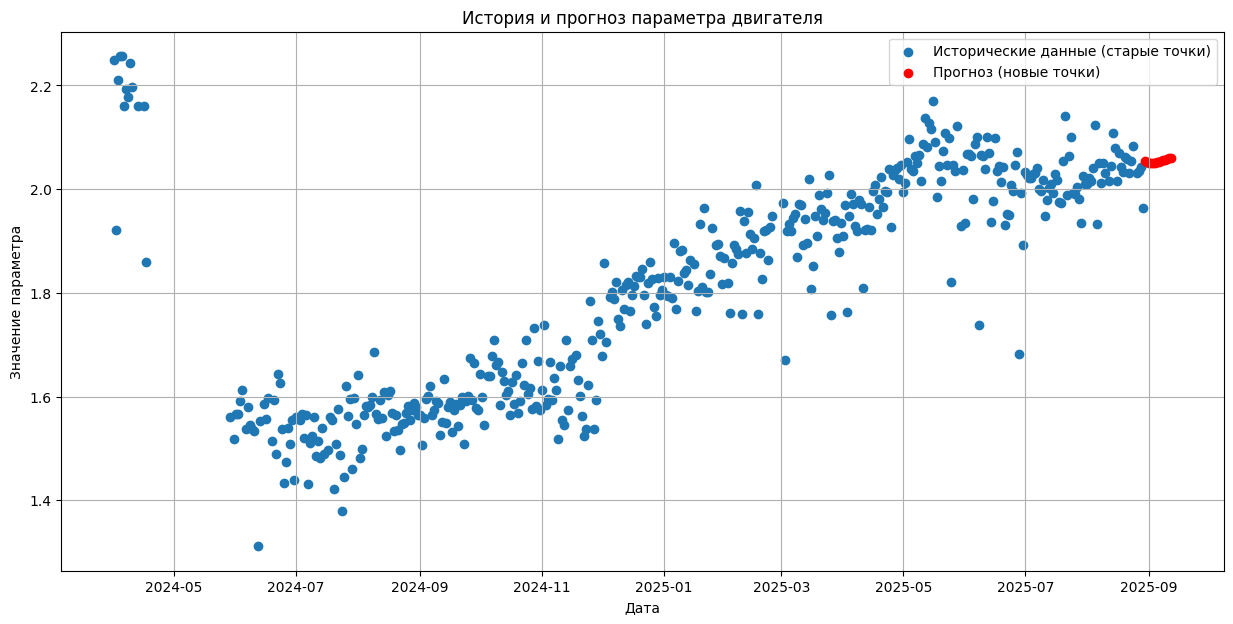

In [18]:
print(f"\n--- ПРОГНОЗ ТЕНДЕНЦИИ НА СЛЕДУЮЩИЕ {days_to_predict} ДНЕЙ ---")
# Генерация дат для прогноза
last_date = daily_data['date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict)

for i, val in enumerate(predicted_values):
    print(f"День {i+1} ({future_dates[i].strftime('%Y-%m-%d')}): Прогнозируемое значение = {val[0]:.4f}")

# Построение графика
print("\nОтображение графика...")
plt.figure(figsize=(15, 7))
plt.scatter(daily_data['date'], daily_data['value'], label='Исторические данные (старые точки)')
plt.scatter(future_dates, predicted_values, label='Прогноз (новые точки)', marker='o', color='red')
plt.title('История и прогноз параметра двигателя')
plt.xlabel('Дата')
plt.ylabel('Значение параметра')
plt.legend()
plt.grid(True)
plt.show()


In [17]:






# --- Шаг 2: Создание обучающих последовательностей ---

# Функция для "нарезки" данных на обучающие примеры




# Преобразование данных в формат для LSTM: [образцы, временные шаги, признаки]



# --- Шаг 3: Создание и обучение LSTM модели ---



# Обучение модели на ваших данных



# --- Шаг 4: Прогнозирование на 14 дней вперед ---



# Берем последнюю известную последовательность из реальных данных







# --- Шаг 5: Вывод результата ---



